In [2]:
# import denpendency
import os 
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models 

In [3]:
dir = '/teamspace/studios/this_studio/Bio_sec/Extracted Faces/Extracted Faces'
random.seed(42)

def get_triplets(dir):
    triplets = []
    folders = list(os.listdir(dir))
    for folder in folders:
        folder_path = os.path.join(dir, folder)
        files = list(os.listdir(folder_path))
        for i, anchor_file in enumerate(files[:-1]):
            for _, positive_file in enumerate(files[i+1:]):
                
                negative_folder = random.choice(folders)
                while negative_folder == folder:
                    negative_folder = random.choice(folders)
                negative_file = random.choice(os.listdir(os.path.join(dir, negative_folder)))

                image_anchor = Image.open(os.path.join(dir, folder, anchor_file))
                image_positive = Image.open(os.path.join(dir, folder, positive_file))
                image_negative = Image.open(os.path.join(dir, negative_folder, negative_file))

                triplets.append((image_anchor, image_positive, image_negative))

    return triplets

triplets = get_triplets(dir)
print(len(triplets))

31990


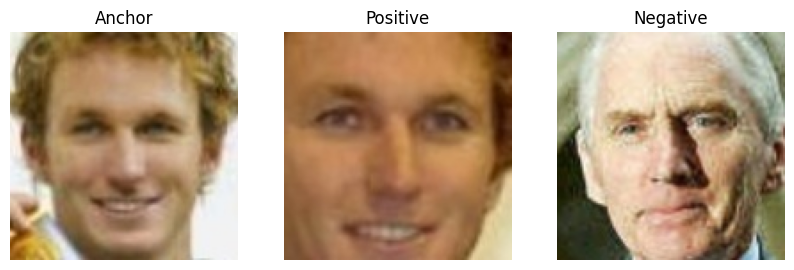

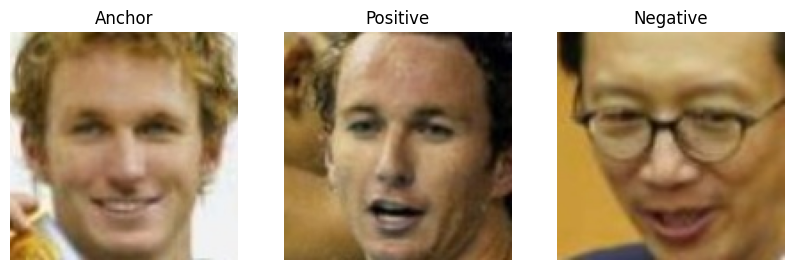

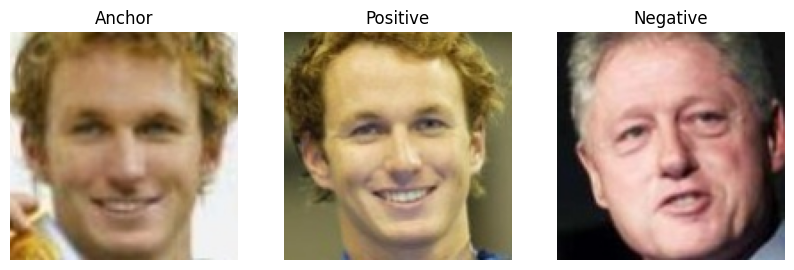

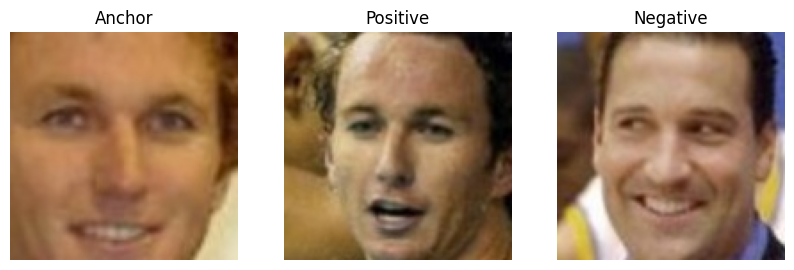

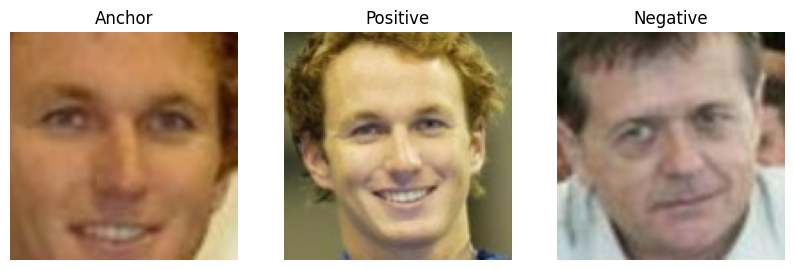

In [4]:
def show_triplet(triplet):

    figure = plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(triplet[0], cmap='gray')
    plt.title('Anchor')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(triplet[1], cmap='gray')
    plt.title('Positive')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(triplet[2], cmap='gray')
    plt.title('Negative')

    plt.axis('off')
    plt.show()
# afficher 5 examples de triplets(anchor, positive, negative)

for i in range(5):
    show_triplet(triplets[i])

In [5]:
class TripletDataset(Dataset):
    def __init__(self, triplets):
        self.triplets = triplets
        self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]),std=torch.tensor([0.229, 0.224, 0.225])),
                transforms.Resize((128, 128))
            ])

    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        return anchor, positive, negative

dataset = TripletDataset(triplets)

### split the datas into train and test split and get the dataloaders

In [6]:
# deviser le dataset en train_split et test_split
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)

batch_size = 128
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)
    

### define the model

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = models.get_model('resnet18', weights = models.ResNet18_Weights.DEFAULT)
        # modify the finale fully connected layer with this sequential
        self.model.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128)
        )

        for name, param in self.model.named_parameters():
            if "fc" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        x = self.model(x)
        x = F.normalize(x, p=2.0, dim=-1)  # L2 normalization
        return x
    
model = Model()
print('trainable parameters:',sum(p.numel() for p in model.parameters() if p.requires_grad))
print('non trainable parameters:',sum(p.numel() for p in model.parameters() if not p.requires_grad))



trainable parameters: 164736
non trainable parameters: 11176512


### define the loss function and optimizer

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
# define the loss function
loss_function = nn.TripletMarginLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001) # 3e-4
# optimizer = optim.Adam(model.parameters(), lr=3e-4) # 

epochs = 50
test_losses = []
train_losses = []

### train loop

In [9]:
for epoch in range(epochs):
    train_loss= 0
    model.train()
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        anchor, positive, negative = batch
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        with torch.autocast(device_type = 'cuda', dtype = torch.bfloat16):
            anchor_encoding = model(anchor)
            positive_encoding = model(positive)
            negative_encoding = model(negative)
            loss = loss_function(anchor_encoding, positive_encoding, negative_encoding)
        
        loss.backward()
        train_loss += loss.item() * batch_size
        optimizer.step()

    train_loss /= len(train_loader.dataset)

    train_losses.append(train_loss)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            anchor, positive, negative = batch
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            with torch.autocast(device_type = 'cuda', dtype = torch.bfloat16):
                anchor_encoding = model(anchor)
                positive_encoding = model(positive)
                negative_encoding = model(negative)
                loss = loss_function(anchor_encoding, positive_encoding, negative_encoding)
            
            test_loss += loss.item() * batch_size

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Epoch {epoch}, loss_train: {train_loss:.4f} Loss_test: {test_loss:.4f}")


Epoch 0, loss_train: 0.6097 Loss_test: 0.4558
Epoch 1, loss_train: 0.4079 Loss_test: 0.3675
Epoch 2, loss_train: 0.3286 Loss_test: 0.3148
Epoch 3, loss_train: 0.2842 Loss_test: 0.2852
Epoch 4, loss_train: 0.2492 Loss_test: 0.2628
Epoch 5, loss_train: 0.2312 Loss_test: 0.2511
Epoch 6, loss_train: 0.2120 Loss_test: 0.2393
Epoch 7, loss_train: 0.2016 Loss_test: 0.2265
Epoch 8, loss_train: 0.1887 Loss_test: 0.2248
Epoch 9, loss_train: 0.1799 Loss_test: 0.2174
Epoch 10, loss_train: 0.1710 Loss_test: 0.2098
Epoch 11, loss_train: 0.1647 Loss_test: 0.2085
Epoch 12, loss_train: 0.1606 Loss_test: 0.2041
Epoch 13, loss_train: 0.1539 Loss_test: 0.2013
Epoch 14, loss_train: 0.1485 Loss_test: 0.1971
Epoch 15, loss_train: 0.1447 Loss_test: 0.1943
Epoch 16, loss_train: 0.1408 Loss_test: 0.1900
Epoch 17, loss_train: 0.1359 Loss_test: 0.1891
Epoch 18, loss_train: 0.1321 Loss_test: 0.1872
Epoch 19, loss_train: 0.1307 Loss_test: 0.1873
Epoch 20, loss_train: 0.1277 Loss_test: 0.1827
Epoch 21, loss_train: 0

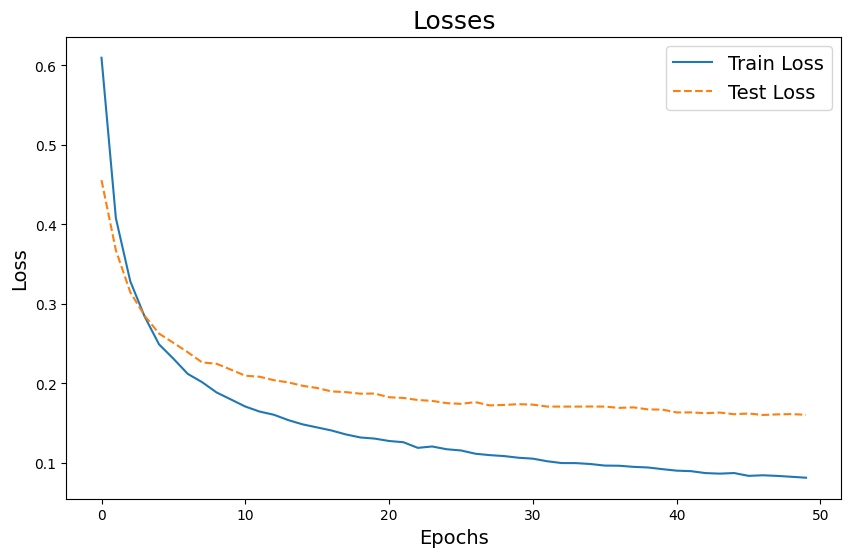

In [10]:
plt.figure(figsize=(10, 6))

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, "--", label='Test Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Losses', fontsize=18)
plt.legend(fontsize=14)
plt.grid(False)
plt.show()

In [16]:
# save the trained model
save_chekp = '/teamspace/studios/this_studio/Bio_sec/model.pth'
torch.save(model.state_dict(), save_chekp)

In [19]:
# load the model
model_path = '/teamspace/studios/this_studio/Bio_sec/model.pth'
model = Model()
model.load_state_dict(torch.load(model_path))
model.to(device)

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [20]:
def get_distances(face_list1, face_list2, model, seuil=0.6):
    # Ensure model and data are on the same device
    face_list1 = face_list1.to(device)
    face_list2 = face_list2.to(device)
    
    # Compute embeddings
    model.eval()
    with torch.no_grad():
        tensor1 = model(face_list1)
        tensor2 = model(face_list2)
    
    # Squared Euclidean distance
    distance = torch.sum((tensor1 - tensor2) ** 2, dim=-1)
    # prediction = torch.where(distance <= seuil, 1, 0)
    
    return distance.cpu().numpy()

# Initialize lists for distances
dap = []  # Distances for anchor-positive pairs
dan = []  # Distances for anchor-negative pairs

# Process all batches
for data in test_loader:
    anchor, positive, negative = data
    dist_ap = get_distances(anchor, positive, model)
    dist_an = get_distances(anchor, negative, model)
    
    dap.append(dist_ap.reshape(-1))
    dan.append(dist_an.reshape(-1))

# Convert to numpy arrays
dap = np.concatenate(dap)
dan = np.concatenate(dan)

# Calculate metrics across thresholds
seuils = np.linspace(min(dap.min(), dan.min()), 
                    max(dap.max(), dan.max()), 
                    1000)

frr, far, err = [], [], []
min_diff = float('inf')
eer = 0.5

for seuil in seuils:
    # Calculate error rates
    fa = np.sum(dap >= seuil) / len(dap)  # FRR
    fr = np.sum(dan <= seuil) / len(dan)  # FAR
    
    frr.append(fr)
    far.append(fa)
    err.append((fr + fa) / 2)
    
    # Find EER (exact intersection point)
    if abs(fr - fa) < min_diff:
        min_diff = abs(fr - fa)
        eer = (fr + fa) / 2

# Find threshold where FRR and FAR are closest
eer_index = np.argmin(np.abs(np.array(frr) - np.array(far)))
eer_threshold = seuils[eer_index]

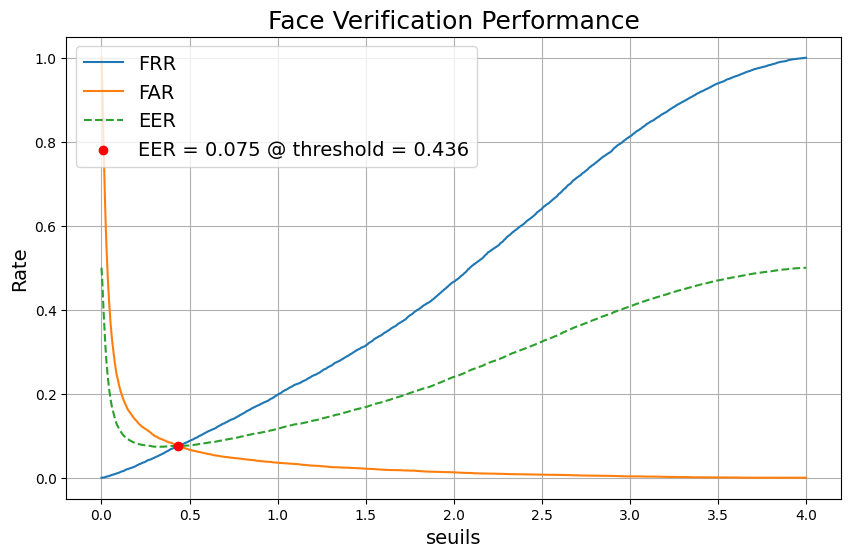

In [21]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(seuils, frr, label='FRR')
plt.plot(seuils, far, label='FAR')
plt.plot(seuils, err, '--', label='EER')

# Mark EER point
plt.scatter(eer_threshold, eer, color='red', zorder=5, 
           label=f'EER = {eer:.3f} @ threshold = {eer_threshold:.3f}')

plt.xlabel('seuils', fontsize=14)
plt.ylabel('Rate', fontsize = 14)
plt.title('Face Verification Performance', fontsize=18)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()


In [22]:
# Print key metrics
print(f'Equal Error Rate (EER): {eer:.3%}')
print(f'Optimal Threshold: {eer_threshold:.3f}')
print(f'FRR at EER: {frr[eer_index]:.3%}')
print(f'FAR at EER: {far[eer_index]:.3%}')

Equal Error Rate (EER): 7.549%
Optimal Threshold: 0.436
FRR at EER: 7.549%
FAR at EER: 7.549%


In [24]:
# install yolo
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.5/913.5 kB 108.4 MB/s eta 0:00:00


In [ ]:
import 